***STACK EXCHANGE RECOMMENDATION SYSTEM***

We have built a recommendation system which analyzes Stack Exchange Community user data and recommends questions for users and also recommend Communities to users of similar interests and likes.

**TEAM NAME**: *Scrapex Legends*

**TEAM MEMBERS**: *Harish, Hetansh, Ishan and Neha*

Our dataset is sourced from the following:

1.   https://api.stackexchange.com/
2.   https://stackexchange.com/sites/
3.   https://data.stackexchange.com/stackoverflow/query/new


## **Question Recommendations**
We first create a user-centric recommendation system for the biggest stack exchange community, stack overflow. We use the query stack exchange website to obtain data of top 200 users by number of posts. We will take 90 questions sorted by upvotes for each user, resulting in a total of 18,000 questions.
After we are satisfied with our recommendation system used above, we repeat the process for the 10 communities, this time combining the data for all communities so our users can get recommended questions from different communities as well. However, since all communities don't have even 30 questions asked in top 50 user with most questions asked, we will only take upto 30 posts from each user, sorted by upvotes

In [ ]:
#Installing necesary libraries
!pip install rake_nltk
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.5 MB/s 


In [ ]:
# Import the necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from rake_nltk import Rake
import pandas as pd
import numpy as np
import requests
import time
import nltk
import re
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import visualkeras
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
#downloading and importing the stopwords, tokenizer package from nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

First, we tried recommending users from the same community, and then went on to apply a similar model to the dataset of 10 different communities.

In [ ]:
#mounting the colab drive to fetch the data for a single community
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the data from the drive
df_questions = pd.read_csv('question_stack.csv')
df_questions.head()

,Unnamed: 0,Name,Question Asked,Upvotes,Question Tags
0,0,\n David542\n,How do I fetch all Git branches?,\n2104\nvotes\n,",git,branch,git-branch"
1,1,\n David542\n,How do I check if directory exists in Python?,\n1460\nvotes\n,",python,directory"
2,2,\n David542\n,How to move a file in Python?,\n1321\nvotes\n,",python,file,file-handling,python-os"
3,3,\n David542\n,Add a CSS border on hover without moving the e...,\n274\nvotes\n,",css"
4,4,\n David542\n,What's the purpose of Django setting ‘SECRET_K...,\n229\nvotes\n,",python,django,security,encryption"


In [ ]:
#From the data we will select only the columns that we require
df = df_questions[['Name', 'Question Asked', 'Upvotes', 'Question Tags']]
df.head()

,Name,Question Asked,Upvotes,Question Tags
0,\n David542\n,How do I fetch all Git branches?,\n2104\nvotes\n,",git,branch,git-branch"
1,\n David542\n,How do I check if directory exists in Python?,\n1460\nvotes\n,",python,directory"
2,\n David542\n,How to move a file in Python?,\n1321\nvotes\n,",python,file,file-handling,python-os"
3,\n David542\n,Add a CSS border on hover without moving the e...,\n274\nvotes\n,",css"
4,\n David542\n,What's the purpose of Django setting ‘SECRET_K...,\n229\nvotes\n,",python,django,security,encryption"


In [ ]:
# We will clean the data and remove the unwanted special characters to help with keyword extraction and overall readability
df['Name'] = df['Name'].str.replace('\n', '')
df['Upvotes'] = df['Upvotes'].str.replace(r'[a-zA-Z]', '')
df['Upvotes'] = df['Upvotes'].str.replace('\n', '')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWar

,Name,Question Asked,Upvotes,Question Tags
0,David542,How do I fetch all Git branches?,2104,",git,branch,git-branch"
1,David542,How do I check if directory exists in Python?,1460,",python,directory"
2,David542,How to move a file in Python?,1321,",python,file,file-handling,python-os"
3,David542,Add a CSS border on hover without moving the e...,274,",css"
4,David542,What's the purpose of Django setting ‘SECRET_K...,229,",python,django,security,encryption"


In [ ]:
#Create a copy of the data
df_new = df.copy()
df_new.head()

,Name,Question Asked,Upvotes,Question Tags
0,David542,How do I fetch all Git branches?,2104,",git,branch,git-branch"
1,David542,How do I check if directory exists in Python?,1460,",python,directory"
2,David542,How to move a file in Python?,1321,",python,file,file-handling,python-os"
3,David542,Add a CSS border on hover without moving the e...,274,",css"
4,David542,What's the purpose of Django setting ‘SECRET_K...,229,",python,django,security,encryption"


In [ ]:
# Cleaning the questions columns further to remove characters like $,%,_,-,{},[], etc
df_new['Question Asked'] = df_new['Question Asked'].transform(lambda x : re.sub(r'[^a-zA-Z0-9 ]', '', x))
df_new['Question Asked'] = df_new['Question Asked'].transform(lambda x : x.astype(str).str.lower())
df_new.head()

,Name,Question Asked,Upvotes,Question Tags
0,David542,how do i fetch all git branches,2104,",git,branch,git-branch"
1,David542,how do i check if directory exists in python,1460,",python,directory"
2,David542,how to move a file in python,1321,",python,file,file-handling,python-os"
3,David542,add a css border on hover without moving the e...,274,",css"
4,David542,whats the purpose of django setting secretkey,229,",python,django,security,encryption"


In [ ]:
#Rake stands for rapid active keyword extraction, basically it will identify the most relevant words from a text
# and remove the stopwords/other unnecessary words
rake = Rake()
df_new['Key_words'] = ''
for i, r in df_new.iterrows():
  rake.extract_keywords_from_text(r['Question Asked'])
  key_words_dict_scores = rake.get_word_degrees()
  r['Key_words'] = list(key_words_dict_scores.keys())

In [ ]:
# Further text processing to create the key words column, used by the recommendation system
df_new['Question Tags'] = df_new['Question Tags'].str.split(',')
df_new['Key_words'] = df_new['Question Tags'] + df_new['Key_words']
df_new['Key_words'] = df_new['Key_words'].transform( lambda x : x[1:] )
df_new['Name'] = df_new['Name'].transform( lambda x : x.strip())

In [ ]:
df_new.head()

,Name,Question Asked,Upvotes,Question Tags,Key_words
0,David542,how do i fetch all git branches,2104,"[, git, branch, git-branch]","[git, branch, git-branch, fetch, git, branches]"
1,David542,how do i check if directory exists in python,1460,"[, python, directory]","[python, directory, check, directory, exists, ..."
2,David542,how to move a file in python,1321,"[, python, file, file-handling, python-os]","[python, file, file-handling, python-os, move,..."
3,David542,add a css border on hover without moving the e...,274,"[, css]","[css, add, css, border, hover, without, moving..."
4,David542,whats the purpose of django setting secretkey,229,"[, python, django, security, encryption]","[python, django, security, encryption, whats, ..."


In [ ]:
# Creating a checkpoint by saving the csv in case of data loss
df_new.to_csv('data_final.csv')

In [ ]:
# continuing with the data we just created
df_new = pd.read_csv('data_final.csv')

In [ ]:
# Selecting the required columns from the data
df_new = df_new[['Name', 'Question Asked', 'Upvotes', 'Key_words']]
df_new['Name'] = df_new['Name'].transform( lambda x : x.strip())

In [ ]:
# For our case, we will use the count vectorizer to vectorize our key words
count = CountVectorizer(analyzer = lambda x : x)
questions = pd.Series(df_new['Question Asked'])

In [ ]:
'''This function defines the recommendation system,
We will create seperate dataframe for each user and find its cosine similarity
with the rest, we do this because we do not want the user to be recommended questions that
they have already asked'''
def recommend_questions(user_name):
  recommended_question_idx = []
  recommendations = []
  df_user = df_new.loc[df_new['Name'] == user_name]
  df_others = df_new.loc[df_new['Name'] != user_name]
  df_others_list = list(df_others['Question Asked'])
  count = CountVectorizer(analyzer = lambda x : x)
  cv_matrix = count.fit_transform(df_new['Key_words']).toarray()
  user_matrix = cv_matrix[df_user.index.values]
  rem_matrix = cv_matrix[df_others.index.values]
  cosine_sim = cosine_similarity(user_matrix, rem_matrix)
  '''
  run a for loop for each question asked by user
  store the top 5 questions indices by similarity score in a list
  find the top 5 most recurring indices in this list, use them to recommend the questions to our user.
  '''
  for i in range(len(df_user)):
    # idx = questions[questions == df_user['Question Asked'].iloc[i]].index[0]
    similarity_score = pd.Series(cosine_sim[i]).sort_values(ascending = False)
    top_5_questions = list(similarity_score.iloc[1:6].index)
    recommended_question_idx.append(top_5_questions)
  recommended_questions = [d for sublist in recommended_question_idx for d in sublist]
  rec_dict = dict( (l, recommended_questions.count(l) ) for l in set(recommended_questions))
  sorted_dict = dict(sorted(rec_dict.items(), key=lambda item: item[1]))
  rec_list = list(sorted_dict.keys())[:5]
  for i in rec_list:
    recommendations.append(df_others_list[i])
  return recommendations

In [ ]:
# We will print the user who asked the question along with the question title,
# we will add the question link in the final version this is just for testing the recommendation system
recommendations_final = []
rec = recommend_questions('David542')
for i in rec:
  name = df['Name'].loc[df_new['Question Asked'] == i].iloc[0]
  question_text = df['Question Asked'].loc[df_new['Question Asked'] == i].iloc[0]
  name = name.strip()
  recs = [name, question_text]
  recommendations_final.append(recs)
recommendations_final

[['Carol.Kar',
  'Showing all posts and custom post types by using a single category'],
 ['Blankman', 'Open existing file, append a single line'],
 ['Blankman', 'Creating a simple XML file using python'],
 ['Greg',
  'why am I getting an "unknown type name NSManagedObjectContext" in this code?'],
 ['Greg',
  'in Ruby can I automatically populate instance variables somehow in the initialize method?']]

In [ ]:
# doing this for multiple users to be sure
recommendations_final = []
rec = recommend_questions('Blankman')
for i in rec:
  name = df['Name'].loc[df_new['Question Asked'] == i].iloc[0]
  question_text = df['Question Asked'].loc[df_new['Question Asked'] == i].iloc[0]
  name = name.strip()
  recs = [name, question_text]
  recommendations_final.append(recs)
recommendations_final

[['Carol.Kar', 'Goutte - Get inner values from $crawler->filter()'],
 ['daydreamer', 'Which datatype should be used for currency?'],
 ['David542',
  'Add a CSS border on hover without moving the element [duplicate]'],
 ['Carol.Kar',
  'Install python package zipline on cloud 9 environment Support workspace python'],
 ['einpoklum', "CMake's execute_process and arbitrary shell scripts"]]

In [ ]:
# one more
recommendations_final = []
rec = recommend_questions('einpoklum')
for i in rec:
  name = df['Name'].loc[df_new['Question Asked'] == i].iloc[0]
  question_text = df['Question Asked'].loc[df_new['Question Asked'] == i].iloc[0]
  name = name.strip()
  recs = [name, question_text]
  recommendations_final.append(recs)
recommendations_final

[['Carol.Kar', 'Grails 2 - Cannot create spring security domain object'],
 ['David542', 'How to make a link act as a file input'],
 ['daydreamer', 'Alembic --autogenerate producing empty migration'],
 ['Greg',
  'is it ok to use of a notification to communication back to the main thread of an IOS app? (cf performSelectorOnMainThread)'],
 ['Greg',
  'core data how to filter (NSPredicate) including a relationship requirement and given the relationship object? [closed]']]

In [ ]:
# Retrieving the query results for 10 selected communities from the google drive folder
import gdown
folder = 'https://drive.google.com/drive/folders/1lgQ2TGmUR21JLWQM7awopSz6E9pFZY06?usp=sharing'
gdown.download_folder(folder)

Retrieving folder list


Processing file 1U6Qnaxsd1qjleT39d4RMRszTriJGZh2S QueryResults_Ask_Ubuntu.csv
Processing file 1n-D5QNrRpOPfJfMDRxPTpgGXG2BFbKXB QueryResults_Data_Science.csv
Processing file 1uxZMkq7ZFa-r5wRPRJQeBLyCWHb6pkSp QueryResults_Database_Admin.csv
Processing file 1ueWWKwXolAsWedFXWz_PmtvqZgcirMu_ QueryResults_Quant.csv
Processing file 1K4_3rW8fEJptADttNHl1wZObG9mtPc08 QueryResults_Server_Fault.csv
Processing file 1aMe5VztPze-cbZ5AvFuszOLJkFkSkHBa QueryResults_Software_Engineering.csv
Processing file 1-Ofw8EUh-uyhWcKEJl-NE75_-GhYHC5T QueryResults_Stack_Overflow.csv
Processing file 1i73Te2HsvPtmdy-qUOEoENXig1-44JV1 QueryResults_Stats.csv
Processing file 16OHFSB1wNiZ4M1B6KMyiamfIpXUe_0Lh QueryResults_SuperUser.csv
Processing file 1HRXtJ-E3Ezf4X7hvFg3OMl6zLSus1z1X QueryResults_Unix.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1U6Qnaxsd1qjleT39d4RMRszTriJGZh2S
To: /content/STACK_CSV_FILES/QueryResults_Ask_Ubuntu.csv
100%|██████████| 1.77k/1.77k [00:00<00:00, 3.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n-D5QNrRpOPfJfMDRxPTpgGXG2BFbKXB
To: /content/STACK_CSV_FILES/QueryResults_Data_Science.csv
100%|██████████| 1.63k/1.63k [00:00<00:00, 3.09MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uxZMkq7ZFa-r5wRPRJQeBLyCWHb6pkSp
To: /content/STACK_CSV_FILES/QueryResults_Database_Admin.csv
100%|██████████| 1.69k/1.69k [00:00<00:00, 2.95MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ueWWKwXolAsWedFXWz_PmtvqZgcirMu_
To: /content/STACK_CSV_FILES/QueryResults_Quant.csv
100%|██████████| 1.56k/1.56k [00:00<00:00, 1.03MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K4_3rW8fEJptADttNHl1wZObG9mtPc08
To: /content/STACK_CSV_FILES/QueryResults_Server_Fault.csv
100%|███

['/content/STACK_CSV_FILES/QueryResults_Ask_Ubuntu.csv',
 '/content/STACK_CSV_FILES/QueryResults_Data_Science.csv',
 '/content/STACK_CSV_FILES/QueryResults_Database_Admin.csv',
 '/content/STACK_CSV_FILES/QueryResults_Quant.csv',
 '/content/STACK_CSV_FILES/QueryResults_Server_Fault.csv',
 '/content/STACK_CSV_FILES/QueryResults_Software_Engineering.csv',
 '/content/STACK_CSV_FILES/QueryResults_Stack_Overflow.csv',
 '/content/STACK_CSV_FILES/QueryResults_Stats.csv',
 '/content/STACK_CSV_FILES/QueryResults_SuperUser.csv',
 '/content/STACK_CSV_FILES/QueryResults_Unix.csv']

In [ ]:
# Now we will create the communities dataset
folder_path = '/content/STACK_CSV_FILES'
list_of_file_names = []
for file in os.listdir(folder_path):
  if file.endswith('.csv'):
    list_of_file_names.append(file)

In [ ]:
#checking to see if all the files have been correctly loaded
list_of_file_names

['QueryResults_Stats.csv',
 'QueryResults_SuperUser.csv',
 'QueryResults_Data_Science.csv',
 'QueryResults_Server_Fault.csv',
 'QueryResults_Unix.csv',
 'QueryResults_Database_Admin.csv',
 'QueryResults_Quant.csv',
 'QueryResults_Ask_Ubuntu.csv',
 'QueryResults_Stack_Overflow.csv',
 'QueryResults_Software_Engineering.csv']

In [ ]:
# extracting community names from the csv file path
communities = []
for name in list_of_file_names:
  new_name = re.sub('QueryResults', '', name)
  name_df = re.sub('_', '', new_name)
  name = re.sub('.csv', '', name_df)
  communities.append(name)
communities

['Stats',
 'SuperUser',
 'DataScience',
 'ServerFault',
 'Unix',
 'DatabaseAdmin',
 'Quant',
 'AskUbuntu',
 'StackOverflow',
 'SoftwareEngineering']

In [ ]:
#creating the dataframe having all the users from all the 10 communities by combining the
# dataframes created from above loaded csv data
df_communities = pd.DataFrame()
for i,file_path in enumerate(list_of_file_names):
  df = pd.read_csv(folder_path + '/' + file_path)
  df['Community'] = communities[i]
  df_communities = pd.concat([df_communities, df])
df_communities.head()

,NumPosts,Id,Reputation,DisplayName,Community
0,298,1005,18269,Tim,Stats
1,295,77179,6078,stats_noob,Stats
2,261,9162,11597,user1205901 - Слава Україні,Stats
3,240,53690,57795,Richard Hardy,Stats
4,227,108150,2315,user321627,Stats


In [ ]:
# this is a list of base url's for the stack communities on which we will be recommending
url_list = ['https://stats.stackexchange.com/users/',
            'https://superuser.com/users/',
            'https://datascience.stackexchange.com/users/',
            'https://serverfault.com/users/',
            'https://unix.stackexchange.com/users/',
            'https://dba.stackexchange.com/users/',
            'https://quant.stackexchange.com/users/',
            'https://askubuntu.com/users/',
            'https://stackoverflow.com/users/',
            'https://softwareengineering.stackexchange.com/users/']

In [ ]:
# checking the data for a particular community
df_communities[df_communities['Community'] == communities[0]]

,NumPosts,Id,Reputation,DisplayName,Community
0,298,1005,18269,Tim,Stats
1,295,77179,6078,stats_noob,Stats
2,261,9162,11597,user1205901 - Слава Україні,Stats
3,240,53690,57795,Richard Hardy,Stats
4,227,108150,2315,user321627,Stats
5,193,113777,33929,Haitao Du,Stats
6,181,40252,5210,An old man in the sea.,Stats
7,180,28986,6292,Charlie Parker,Stats
8,164,56211,9213,rnso,Stats
9,162,163242,1186,The Pointer,Stats


In [ ]:
# creatiing a checkpoint for the above data
df_communities.to_csv('User_Communities')

In [ ]:
#function for creating user profile to extract the questions from using requests and BeautifulSoup
def creating_user_profiles(url, df_users):
    profiles = []
    link = ''
    for i in range(len(df_users)):
        link = url + str(df_users['Id'].iloc[i]) + '/' + df_users['DisplayName'].iloc[i] + '?tab=questions&sort=votes'
        profiles.append(link)
    return profiles

In [ ]:
#creating user profile to extract the questions from using requests and BeautifulSoup
profiles_list = []
for i in range(len(communities)):
  df_community = df_communities[df_communities['Community'] == communities[i]]
  profiles_list.append(creating_user_profiles(url_list[i], df_community))
profiles_list[:5]

In [ ]:
# the length should be 50 * 10 = 500
profiles_list = [link for sublist in profiles_list for link in sublist]
len(profiles_list)

500

In [ ]:
# some websites do not respond to requests unless a user agent is specified, so we will specify it and fetch the data
# for all the users in all the communities. The final result of running this cell will be a list of dictionaries
headers = {
          'user-agent' : 'Hetansh_m'
          }
user_dicts = []
for profile in profiles_list:
  try:
    req = requests.get(url = profile, headers = headers)
    user = req.text
    soup = BeautifulSoup(user, 'html.parser')
    name = soup.find('div', class_ = "flex--item mb12 fs-headline2 lh-xs").get_text()
    question_links = soup.find_all('h3', class_ = "s-post-summary--content-title")
    upvotes = soup.find_all('div', class_ = "s-post-summary--stats-item s-post-summary--stats-item__emphasized")
    tags = soup.find_all('ul', class_ = "ml0 list-ls-none js-post-tag-list-wrapper d-inline")
    site = profile.split('/')[2]
    time.sleep(2)
  except:
    continue
  for question in range(len(question_links)):
    dict_user = {}
    dict_user['Name'] = name
    dict_user['Question Asked'] = question_links[question].find('a').get_text()
    dict_user['Question Link'] = 'https://' + site + question_links[question].find('a')['href']
    dict_user['Upvotes'] = upvotes[question].get_text()
    question_tags = ''
    q_tag = tags[question].find_all('li', class_ = "d-inline mr4 js-post-tag-list-item")
    for tag in q_tag:
       question_tags += "," + tag.get_text()
    dict_user['Question Tags'] = question_tags
    user_dicts.append(dict_user)

In [ ]:
# ideally the length should be 500 * 30 = 15,000, however not all users have asked 30 questions so we are getting a little less.
len(user_dicts)

14899

In [ ]:
# creating the dataframe of questions and viewing the data
df_questions = pd.DataFrame(user_dicts)
df_questions.head()

,Name,Question Asked,Question Link,Upvotes,Question Tags
0,\n Tim\n,How to understand degrees of freedom?,https://stats.stackexchange.com/questions/1692...,\n328\nvotes\n,",interpretation,degrees-of-freedom,intuition"
1,\n Tim\n,Difference between forecast and prediction?,https://stats.stackexchange.com/questions/6528...,\n49\nvotes\n,",regression,time-series,forecasting,terminology"
2,\n Tim\n,"Mode, Class and Type of R objects",https://stats.stackexchange.com/questions/3212...,\n38\nvotes\n,",r"
3,\n Tim\n,Timing functions in R [closed],https://stats.stackexchange.com/questions/3235...,\n37\nvotes\n,",r"
4,\n Tim\n,Symbolic computation in R?,https://stats.stackexchange.com/questions/4775...,\n27\nvotes\n,",r"


In [ ]:
# saving the data obtained as the above cell takes a while to load
df_questions.to_csv('all_questions.csv')

In [ ]:
# Reading the saved data from the checkpoint
df_questions = pd.read_csv('all_questions.csv')
df_questions.head()

,Unnamed: 0,Name,Question Asked,Question Link,Upvotes,Question Tags
0,0,\n Tim\n,How to understand degrees of freedom?,https://stats.stackexchange.com/questions/1692...,\n328\nvotes\n,",interpretation,degrees-of-freedom,intuition"
1,1,\n Tim\n,Difference between forecast and prediction?,https://stats.stackexchange.com/questions/6528...,\n49\nvotes\n,",regression,time-series,forecasting,terminology"
2,2,\n Tim\n,"Mode, Class and Type of R objects",https://stats.stackexchange.com/questions/3212...,\n38\nvotes\n,",r"
3,3,\n Tim\n,Timing functions in R [closed],https://stats.stackexchange.com/questions/3235...,\n37\nvotes\n,",r"
4,4,\n Tim\n,Symbolic computation in R?,https://stats.stackexchange.com/questions/4775...,\n27\nvotes\n,",r"


In [ ]:
# Taking only the columns we need from the data we have obtained
df_questions = df_questions[['Name', 'Question Asked', 'Upvotes', 'Question Tags', 'Question Link']]
df_questions.head()


,Name,Question Asked,Upvotes,Question Tags,Question Link
0,\n Tim\n,How to understand degrees of freedom?,\n328\nvotes\n,",interpretation,degrees-of-freedom,intuition",https://stats.stackexchange.com/questions/1692...
1,\n Tim\n,Difference between forecast and prediction?,\n49\nvotes\n,",regression,time-series,forecasting,terminology",https://stats.stackexchange.com/questions/6528...
2,\n Tim\n,"Mode, Class and Type of R objects",\n38\nvotes\n,",r",https://stats.stackexchange.com/questions/3212...
3,\n Tim\n,Timing functions in R [closed],\n37\nvotes\n,",r",https://stats.stackexchange.com/questions/3235...
4,\n Tim\n,Symbolic computation in R?,\n27\nvotes\n,",r",https://stats.stackexchange.com/questions/4775...


### We will now process the data as we did for the single community dataset above

In [ ]:
df_questions['Name'] = df_questions['Name'].str.replace('\n', '')
df_questions['Upvotes'] = df_questions['Upvotes'].str.replace(r'[a-zA-Z]', '')
df_questions['Upvotes'] = df_questions['Upvotes'].str.replace('\n', '')
df_questions.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Name,Question Asked,Upvotes,Question Tags,Question Link
0,Tim,How to understand degrees of freedom?,328,",interpretation,degrees-of-freedom,intuition",https://stats.stackexchange.com/questions/1692...
1,Tim,Difference between forecast and prediction?,49,",regression,time-series,forecasting,terminology",https://stats.stackexchange.com/questions/6528...
2,Tim,"Mode, Class and Type of R objects",38,",r",https://stats.stackexchange.com/questions/3212...
3,Tim,Timing functions in R [closed],37,",r",https://stats.stackexchange.com/questions/3235...
4,Tim,Symbolic computation in R?,27,",r",https://stats.stackexchange.com/questions/4775...


In [ ]:
df_questions['Question Asked'] = df_questions['Question Asked'].transform(lambda x : re.sub(r'[^a-zA-Z0-9 ]', '', x))
df_questions['Question Asked'] = df_questions['Question Asked'].transform(lambda x : x.astype(str).str.lower())
df_questions.head()

,Name,Question Asked,Upvotes,Question Tags,Question Link
0,Tim,how to understand degrees of freedom,328,",interpretation,degrees-of-freedom,intuition",https://stats.stackexchange.com/questions/1692...
1,Tim,difference between forecast and prediction,49,",regression,time-series,forecasting,terminology",https://stats.stackexchange.com/questions/6528...
2,Tim,mode class and type of r objects,38,",r",https://stats.stackexchange.com/questions/3212...
3,Tim,timing functions in r closed,37,",r",https://stats.stackexchange.com/questions/3235...
4,Tim,symbolic computation in r,27,",r",https://stats.stackexchange.com/questions/4775...


In [ ]:
rake = Rake()
df_questions['Key_words'] = ''
for i, r in df_questions.iterrows():
  rake.extract_keywords_from_text(r['Question Asked'])
  key_words_dict_scores = rake.get_word_degrees()
  r['Key_words'] = list(key_words_dict_scores.keys())

In [ ]:
df_questions.head()

,Name,Question Asked,Upvotes,Question Tags,Question Link,Key_words
0,Tim,how to understand degrees of freedom,328,",interpretation,degrees-of-freedom,intuition",https://stats.stackexchange.com/questions/1692...,"[understand, degrees, freedom]"
1,Tim,difference between forecast and prediction,49,",regression,time-series,forecasting,terminology",https://stats.stackexchange.com/questions/6528...,"[difference, forecast, prediction]"
2,Tim,mode class and type of r objects,38,",r",https://stats.stackexchange.com/questions/3212...,"[mode, class, type, r, objects]"
3,Tim,timing functions in r closed,37,",r",https://stats.stackexchange.com/questions/3235...,"[timing, functions, r, closed]"
4,Tim,symbolic computation in r,27,",r",https://stats.stackexchange.com/questions/4775...,"[symbolic, computation, r]"


In [ ]:
df_questions['Question Tags'] = df_questions['Question Tags'].str.split(',')
df_questions['Key_words'] = df_questions['Question Tags'] + df_questions['Key_words']
df_questions['Name'] = df_questions['Name'].transform( lambda x : x.strip())

In [ ]:
df_questions['Key_words'] = df_questions['Key_words'].transform( lambda x : x[1:] )
df_questions.head()

,Name,Question Asked,Upvotes,Question Tags,Question Link,Key_words
0,Tim,how to understand degrees of freedom,328,"[, interpretation, degrees-of-freedom, intuition]",https://stats.stackexchange.com/questions/1692...,"[interpretation, degrees-of-freedom, intuition..."
1,Tim,difference between forecast and prediction,49,"[, regression, time-series, forecasting, termi...",https://stats.stackexchange.com/questions/6528...,"[regression, time-series, forecasting, termino..."
2,Tim,mode class and type of r objects,38,"[, r]",https://stats.stackexchange.com/questions/3212...,"[r, mode, class, type, r, objects]"
3,Tim,timing functions in r closed,37,"[, r]",https://stats.stackexchange.com/questions/3235...,"[r, timing, functions, r, closed]"
4,Tim,symbolic computation in r,27,"[, r]",https://stats.stackexchange.com/questions/4775...,"[r, symbolic, computation, r]"


In [ ]:
users = list(df_questions['Name'].unique())
users[:10]

['Tim',
 'stats_noob',
 'user1205901 - Слава Україні',
 'Richard Hardy',
 'user321627',
 'Haitao Du',
 'An old man in the sea.',
 'Charlie Parker',
 'rnso',
 'The Pointer']

In [ ]:
count = CountVectorizer(analyzer = lambda x : x)

In [ ]:
'''This function defines the recommendation system,
We will create seperate dataframe for each user and find its cosine similarity
with the rest, we do this because we do not want the user to be recommended questions that
they have already asked'''
def recommend_questions(user_name, df_new):
  recommended_question_idx = []
  recommendations = []
  df_user = df_new.loc[df_new['Name'] == user_name]
  df_others = df_new.loc[df_new['Name'] != user_name]
  df_others_list = list(df_others['Question Asked'])
  count = CountVectorizer(analyzer = lambda x : x)
  cv_matrix = count.fit_transform(df_new['Key_words']).toarray()
  user_matrix = cv_matrix[df_user.index.values]
  rem_matrix = cv_matrix[df_others.index.values]
  cosine_sim = cosine_similarity(user_matrix, rem_matrix)
  # run a for loop for each question asked by user
  # store the top 5 questions indices in a list
  # find the top 5 most recurring indices in this list, use them to recommend the questions to our user.
  for i in range(len(df_user)):
    # idx = questions[questions == df_user['Question Asked'].iloc[i]].index[0]
    similarity_score = pd.Series(cosine_sim[i]).sort_values(ascending = False)
    top_5_questions = list(similarity_score[1:6].index)
    recommended_question_idx.append(top_5_questions)
  recommended_questions = [d for sublist in recommended_question_idx for d in sublist]
  rec_dict = dict( (l, recommended_questions.count(l) ) for l in set(recommended_questions))
  sorted_dict = dict(sorted(rec_dict.items(), key=lambda item: item[1]))
  rec_list = list(sorted_dict.keys())[:5]
  for i in rec_list:
    recommendations.append(df_others_list[i])
  return recommendations

In [ ]:
recommendations_final = []
rec = recommend_questions('The Pointer', df_questions)
for i in rec:
  name = df_questions['Name'].loc[df_questions['Question Asked'] == i].iloc[0]
  question_text = df_questions['Question Asked'].loc[df_questions['Question Asked'] == i].iloc[0]
  question_link = df_questions['Question Link'].loc[df_questions['Question Asked'] == i].iloc[0]
  name = name.strip()
  recs = [name, question_text, question_link]
  recommendations_final.append(recs)
recommendations_final

[['Vaccano',
  'why is removing the identity property on a column not supported',
  'https://dba.stackexchange.com/questions/114608/why-is-removing-the-identity-property-on-a-column-not-supported'],
 ['Tim',
  'mode class and type of r objects',
  'https://stats.stackexchange.com/questions/3212/mode-class-and-type-of-r-objects'],
 ['Tim',
  'timing functions in r closed',
  'https://stats.stackexchange.com/questions/3235/timing-functions-in-r'],
 ['Tim',
  'symbolic computation in r',
  'https://stats.stackexchange.com/questions/4775/symbolic-computation-in-r'],
 ['Tim',
  'is there unsupervised regression',
  'https://stats.stackexchange.com/questions/61390/is-there-unsupervised-regression']]

In [ ]:
# We will print the data in pretty table form for better visualisation
idx = np.random.randint(0, len(users))
recommendations_final = []
rec = recommend_questions(users[idx], df_questions)
for i in rec:
  name = df_questions['Name'].loc[df_questions['Question Asked'] == i].iloc[0]
  question_text = df_questions['Question Asked'].loc[df_questions['Question Asked'] == i].iloc[0]
  question_link = df_questions['Question Link'].loc[df_questions['Question Asked'] == i].iloc[0]
  name = name.strip()
  recs = [name, question_text, question_link]
  recommendations_final.append(recs)
pt = PrettyTable()
pt.field_names = ["Name of recommended question's owner", "Question Title", "Question Link"]
pt.add_rows(recommendations_final)
print("Recommendations for Username: ", users[idx])
print(pt)

Recommendations for Username:  Sybil
+--------------------------------------+-----------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
| Name of recommended question's owner |                          Question Title                         |                                                 Question Link                                                 |
+--------------------------------------+-----------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|              Googlebot               | using foreign key and references for on delete cascade in mysql | https://dba.stackexchange.com/questions/14070/using-foreign-key-and-references-for-on-delete-cascade-in-mysql |
|                tomka                 |       in bayesian terminology what does eviden

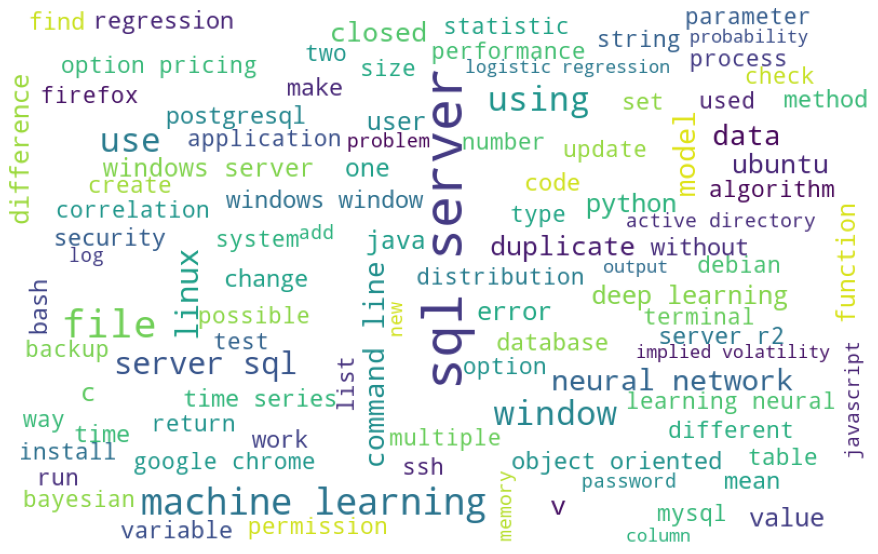

In [ ]:
# making a wordcloud for the entire dataset, this way we can find the most important words
stopwords = set(STOPWORDS)
combined_text = ' '.join(df_questions['Key_words'].sum())

wordcloud = (
    WordCloud(
        width = 800,
        height = 500,
        stopwords=stopwords,
        max_font_size=50,
        max_words=100,
        background_color="white").generate(combined_text))
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Wordcloud for the user : vfclists


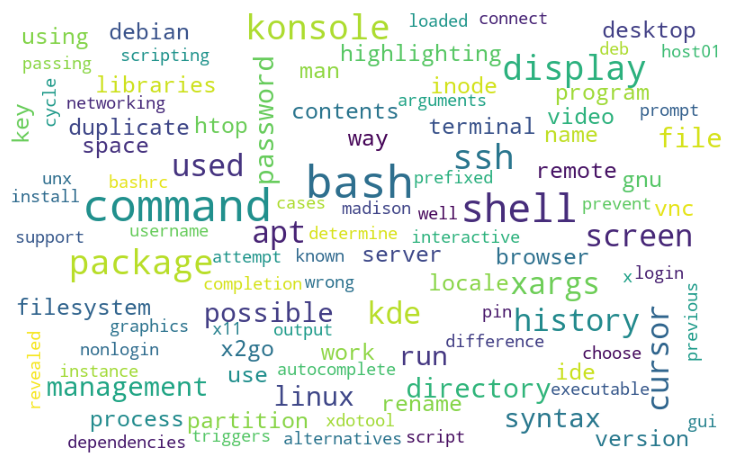

In [ ]:
# making a wordcloud for a particular user at random, this way we can gauge a particular user's interest.
idx = np.random.randint(0, len(users))
df_user = df_questions.loc[df_questions['Name'] == users[idx]]
user_text = ' '.join(df_user['Key_words'].sum())
print('Wordcloud for the user :', users[idx])
wordcloud = (
    WordCloud(
        width = 800,
        height = 500,
        stopwords=stopwords,
        max_font_size=50,
        max_words=100,
        background_color="white").generate(user_text))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

**CONCLUSION FOR QUESTION RECOMMENDATION** :
Our system is giving relevant and satisfactory recommendations from more than one communities to our users. Which is a good thing.
We can further add multiple functionalities like adding new users to this part, we fetch the newest questions that have not yet been answered and select a question from there at random, for which we then create recommendations, this way, the user can get an answer to the question if it has been asked before, thus saving him time. We would also like to be able to perform the keyword extraction based on the body of the questions, and not just the title and the tags.

---



## **Community Recommendation**

We have collected data from top 10 communities for designing our community recommendation system. This system is item based unlike the question recommendation system. We are feeding question tags and keywords corresponding to each community to the model for training. The generated features are then used to recommend top 3 communities with respect to similarity of keywords or question tags present in the user's question

In [ ]:
#Importing file for accessing all questions with community name on stack exchange
questions_df=pd.read_csv('DS_1 Project/questions_df.csv')
questions_df.head()

,q_id,q_title,user_name,q_tags,site
0,11227809,Why is processing a sorted array faster than p...,GManNickG,"['java', 'c++', 'performance', 'cpu-architectu...",stackoverflow
1,927358,How do I undo the most recent local commits in...,Hamza Yerlikaya,"['git', 'version-control', 'git-commit', 'undo']",stackoverflow
2,2003505,How do I delete a Git branch locally and remot...,Matthew Rankin,"['git', 'version-control', 'git-branch', 'git-...",stackoverflow
3,292357,What is the difference between &#39;git pull&#...,pupeno,"['git', 'version-control', 'git-pull', 'git-fe...",stackoverflow
4,231767,What does the &quot;yield&quot; keyword do?,Alex. S.,"['python', 'iterator', 'generator']",stackoverflow


In [ ]:
questions_df.site.value_counts()

superuser        750
gaming           750
math             750
english          750
apple            750
fitness          750
freelancing      750
serverfault      720
askubuntu        660
stackoverflow    659
Name: site, dtype: int64

In [ ]:

questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7289 entries, 0 to 7288
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   q_id       7289 non-null   int64 
 1   q_title    7289 non-null   object
 2   user_name  7288 non-null   object
 3   q_tags     7289 non-null   object
 4   site       7289 non-null   object
dtypes: int64(1), object(4)
memory usage: 284.9+ KB


In [ ]:
#Renaming q_tags as keywords
questions_df.rename(columns={'q_tags':'Key_words'}, inplace=True)
questions_df.head()

,q_id,q_title,user_name,Key_words,site
0,11227809,Why is processing a sorted array faster than p...,GManNickG,"['java', 'c++', 'performance', 'cpu-architectu...",stackoverflow
1,927358,How do I undo the most recent local commits in...,Hamza Yerlikaya,"['git', 'version-control', 'git-commit', 'undo']",stackoverflow
2,2003505,How do I delete a Git branch locally and remot...,Matthew Rankin,"['git', 'version-control', 'git-branch', 'git-...",stackoverflow
3,292357,What is the difference between &#39;git pull&#...,pupeno,"['git', 'version-control', 'git-pull', 'git-fe...",stackoverflow
4,231767,What does the &quot;yield&quot; keyword do?,Alex. S.,"['python', 'iterator', 'generator']",stackoverflow


In [ ]:
#Changing datatype to view keywords column as a list of strings
from ast import literal_eval
questions_df['Key_words'] = questions_df['Key_words'].apply(lambda x: literal_eval(str(x)))

# Creating Keywords Dataframe
key_df =questions_df['Key_words'].str.join(',').str.get_dummies(',').astype('uint8')

#Using questions id as index to refer to the original question
key_df['id']= questions_df['q_id']
key_df.set_index('id', inplace=True)

In [ ]:
#Reducing columns after one hot encoding to have only relevant columns having atleast 0.1% of the rows filled
for col in key_df.columns:

  if key_df[col].sum()<round(len(key_df)*0.001): # approximately 0.1% of total number of rows

     key_df.drop(col, axis=1, inplace=True)
key_df.head()

,.net,64-bit,abbreviations,abdominals,abstract-algebra,accounting,achievements,active-directory,adjectives,adverbs,...,workout,workout-routines,writing,writing-style,xcode,xcom-enemy-unknown,xorg,zelda-breath-of-the-wild,zip,zsh
id,,,,,,,,,,,,,,,,,,,,,
11227809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
927358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2003505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


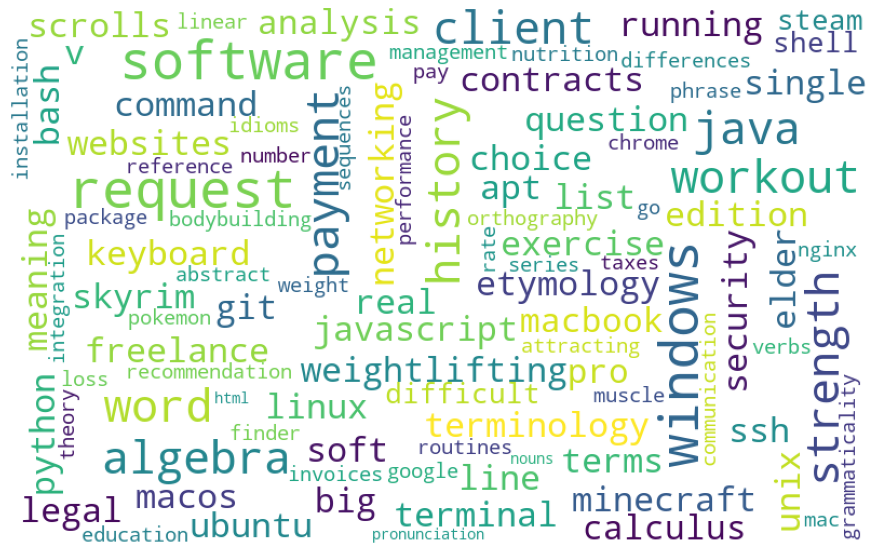

In [ ]:
#Popular keyword distribution across different communities

top100 = key_df.sum(axis=0).sort_values(ascending=False)[:100]
type(top100.index)
text=' '.join(top100.index)
#Generating word cloud for top 100 keywords in the dataset
wordcloud = (
    WordCloud(
        width = 800,
        height = 500,

        max_font_size=50,
        max_words=100,
        background_color="white").generate(text))
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [ ]:
#Saving the keywords dataframe
key_df.to_csv('DS_1 Project/keywords.csv')

In [ ]:
key_df = pd.read_csv('DS_1 Project/keywords.csv', index_col=0)
key_df.head()

,.net,64-bit,abbreviations,abdominals,abstract-algebra,accounting,achievements,active-directory,adjectives,adverbs,...,workout,workout-routines,writing,writing-style,xcode,xcom-enemy-unknown,xorg,zelda-breath-of-the-wild,zip,zsh
id,,,,,,,,,,,,,,,,,,,,,
11227809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
927358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2003505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Adding community column in the dataframe to be used as target variable
key_df['Community']=questions_df.site

In [ ]:
#Assigning feature variables into X and target variable into y

y= key_df['Community']
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

y= label_encoder.fit_transform(y)

X = key_df.drop(['Community'], axis=1)

#Number of communities to classify from
n_communities=len(np.unique(y))

#Creating a train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.8)

In [ ]:
#Creating a deep learning model

model_1 = models.Sequential(name='Community_Recommender')
model_1.add(layers.Dense(64, input_shape=(X_train.iloc[0].shape),))
model_1.add(tf.keras.layers.BatchNormalization())
model_1.add(tf.keras.layers.Activation('linear'))
model_1.add(layers.Dense(32))
model_1.add(tf.keras.layers.BatchNormalization())
model_1.add(tf.keras.layers.Activation('linear'))
model_1.add(layers.Dense(n_communities,  activation='softmax'))

# View the model summary
model_1.summary()

Model: "Community_Recommender"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                37952     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32)      

In [ ]:
#Viewing a model
visualkeras.layered_view(model_1)



In [ ]:
# Compile the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=optimizers.Adam(learning_rate=0.001), metrics= [tf.keras.metrics.SparseCategoricalAccuracy()])

# Save the history about the model
model_1.fit(X_train,y_train, epochs=50, batch_size=4, verbose=1)

Epoch 1/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.4788 - sparse_categorical_accuracy: 0.8643
Epoch 2/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.4861 - sparse_categorical_accuracy: 0.8637
Epoch 3/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.4564 - sparse_categorical_accuracy: 0.8700
Epoch 4/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.4751 - sparse_categorical_accuracy: 0.8707
Epoch 5/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.4712 - sparse_categorical_accuracy: 0.8633
Epoch 6/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.4581 - sparse_categorical_accuracy: 0.8700
Epoch 7/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5024 - sparse_categorical_accuracy: 0.8609
Epoch 8/50
1458/1458 [==============================] - 2s 1ms/step - loss: 0.5086 - sparse_categorical_accuracy: 0.8625
Epoch 9/50
1458/1458 [==========

In [ ]:
#Saving the model
model_1.save('DS_1 Project/com_recom.h5')

In [ ]:
#Loading the model
model = tf.keras.models.load_model('DS_1 Project/com_recom.h5')

In [ ]:
#Evaluating model on the test set
loss, acc=model.evaluate(X_test, y_test)
print(f'The accuracy of the model on the test set is {acc*100:.4f}')

46/46 [==============================] - 0s 1ms/step - loss: 0.9594 - sparse_categorical_accuracy: 0.7867
The accuracy of the model on the test set is 78.6694


In [ ]:
#Prediction on a random user question
idx = np.random.randint(0, len(X))
pred=model.predict(np.expand_dims(X.iloc[idx], axis=0))
ques_asked = questions_df['q_title'][questions_df['q_id']==X.index.values[idx]].values
print(f'The question asked by the user is',ques_asked)

1/1 [==============================] - 0s 21ms/step
The question asked by the user is ['When working with another freelancer, how do we resolve disagreements on what projects to take?']


In [ ]:
#Top 3 communities to recommend
top3=np.argsort(pred)[:,:3]
top3 =[label_encoder.inverse_transform(t) for t in top3]
# # top3 = ', '.join(str(x) for x in top3)
print('The top 3 community recommendations for the user are:')

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Recommended Communities"])
for x in top3[0]:
  myTable.add_row([x])
print(myTable)

The top 3 community recommendations for the user are:
+-------------------------+
| Recommended Communities |
+-------------------------+
|       freelancing       |
|           math          |
|          apple          |
+-------------------------+


**CONCLUSION**
We have proposed an item-based multi-class classification model for community recommendation with classfication accuracy of approx 78.67% on the test data and predicted top 3 communities based on the question asked.
